# Overview

This exploratory data analysis (EDA) examines the Polish apartment market using a dataset sourced from Kaggle: Apartment Prices in Poland. The goal of this project is to gain insights into the housing market, identify key trends, and understand the factors influencing apartment availability and features. Through this analysis, I aim to provide valuable information for potential buyers, investors, and policymakers.
## Tools Used

To conduct this analysis, I utilized several key tools:

* Python: The main programming language used for data analysis.

* Pandas: To load, clean, and manipulate the dataset.

* NumPy: For numerical operations and data transformati* ons.

* Matplotlib & Seaborn: For visualizing key insights and trends.

* GeoPandas: For spatial analysis and geographic visualizations.

## The Questions
Below are the questions I want to answer in my project:

* How do property prices vary across different cities and regions in Poland, and what factors contribute to these variations (e.g., property type, amenities, distance to the city center)?
* What is the correlation between the presence of amenities (e.g., parking, elevator, storage) and the price of properties in different regions?
* How does the distance to the city center influence the price ?
* How do the number of rooms, building age, and property type affect the distribution of property prices in the dataset?
* What trends can be identified in the rental or sales market ?


# Importing Libraries and data

In [2]:
# Python version used
from platform import python_version
print('Python Version Used in this Jupyter Notebook:', python_version())

Python Version Used in this Jupyter Notebook: 3.12.8


In [57]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.patches import Patch
import plotly.express as px
from matplotlib.lines import Line2D

In [4]:
# list to store all dataframes
all_dfs = []

#loading apartment rental data
for i in range(1,7):
    file_path = f'data/apartments_rent_pl_2024_0{i}.csv'
    df = pd.read_csv(file_path)
    df['Month'] = i
    globals()[f'df_month_{i}'] = df
    all_dfs.append(df)

# Concatenate all monthly DataFrames
df = pd.concat(all_dfs, ignore_index=True)

df.sample(5)

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,Month
6334,04cd5b9a20cefdc4b5ad023aca1a7da3,warszawa,NaN,65.0,3.0,3.0,3.0,NaN,52.277386,20.983159,...,condominium,NaN,NaN,yes,yes,yes,no,no,4500,1
14843,18754912f800a058b4ddf19bf6ef9fb3,warszawa,NaN,47.0,2.0,4.0,8.0,NaN,52.294300,21.027800,...,condominium,NaN,NaN,no,no,yes,no,no,2800,2
22755,0b7aea766f00a588b826e4b603d0819c,warszawa,blockOfFlats,83.6,4.0,3.0,4.0,2009.0,52.249580,20.892430,...,condominium,NaN,NaN,no,yes,yes,yes,no,5490,3
34961,d469de80bc3cefeecba70282fb920efe,warszawa,apartmentBuilding,88.0,3.0,1.0,4.0,2010.0,52.160674,21.079420,...,condominium,brick,premium,yes,no,yes,no,no,6000,4
34620,2caf451393601519ad8d084e8f04ec40,warszawa,blockOfFlats,125.0,4.0,NaN,NaN,NaN,52.153033,21.077427,...,condominium,NaN,NaN,no,no,yes,no,no,11500,4


# Data Cleaning
Initial data cleaning tasks were performed to remove inconsistencies, handle missing values, and standardize formats for analysis.

In [140]:
# Checking for missing values (%)
(df
 .isna()
 .sum()
 .divide(df.shape[0]).multiply(100).round(2) # calculate the percentage of missing values
 .astype(str) + '%' # Append a percent sign
)

index                     0.0%
city                      0.0%
type                    22.77%
squareMeters              0.0%
rooms                     0.0%
floor                   12.26%
floorCount               1.86%
buildYear               26.93%
centreDistance            0.0%
poiCount                  0.0%
schoolDistance           0.01%
clinicDistance           0.06%
postOfficeDistance       0.03%
kindergartenDistance     0.04%
restaurantDistance       0.19%
collegeDistance          1.24%
pharmacyDistance          0.1%
ownership                 0.0%
hasParkingSpace           0.0%
hasBalcony                0.0%
hasElevator               0.0%
hasSecurity               0.0%
hasStorageRoom            0.0%
price                     0.0%
Month                     0.0%
dtype: object

In [6]:
# drop unnecessary to analyze columns
df.drop(['id','latitude','longitude','buildingMaterial','condition'], axis=1, inplace=True)

In [109]:
# Convert the specified columns to boolean
properties = ['hasStorageRoom', 'hasSecurity', 'hasElevator', 'hasBalcony', 'hasParkingSpace']

# Convert 'yes'/'no' to boolean
df[properties] = df[properties].replace({'yes': True, 'no': False}).infer_objects(copy=False)
df[properties] = df[properties].astype(bool)

In [8]:
# Dropping duplicates if any
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

# The Analysis


### 1. Number of Property Types by City

To understand the availability of different property types, I analyzed their distribution across major Polish cities. By grouping the dataset based on city and property type, I calculated the number of occurrences for each type in various cities.

In [9]:
# Count property types per city and select the 8 cities with the most offers  
offers_per_city = df.dropna(subset=['type']).copy()
offers_per_city = offers_per_city.groupby('city')['type'].value_counts().unstack(fill_value=0)
offers_per_city = offers_per_city.sort_values(by=['apartmentBuilding', 'blockOfFlats', 'tenement'], ascending=True).tail(8)
offers_per_city

type,apartmentBuilding,blockOfFlats,tenement
city,,,
szczecin,262,475,97
katowice,675,672,161
poznan,719,1172,264
gdansk,724,912,198
lodz,1450,1452,284
wroclaw,1938,1671,430
krakow,3624,3755,1207
warszawa,7804,5141,2516


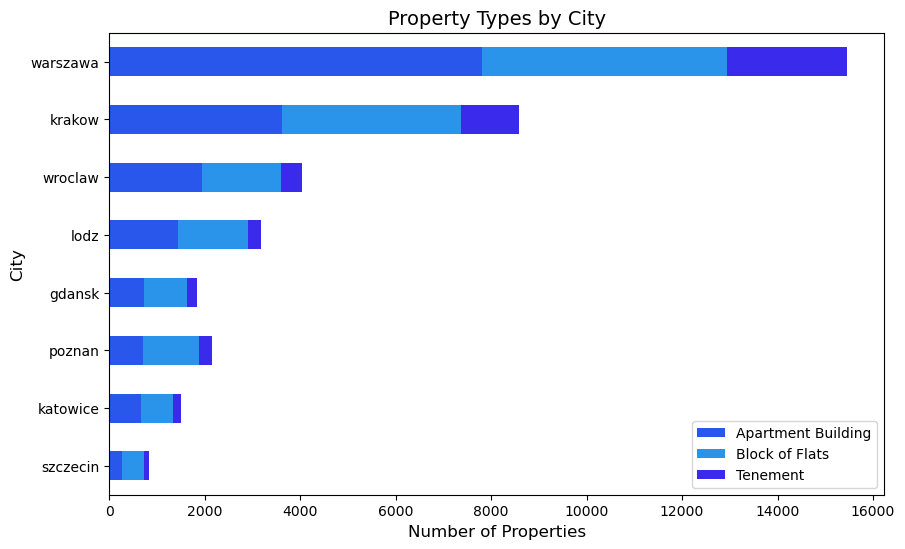

In [10]:
plt = offers_per_city.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=['#2A57EB', '#2A94EB', '#3A2AEB']
    )

plt.set_title('Property Types by City', fontsize=14)
plt.set_xlabel('Number of Properties', fontsize=12)
plt.set_ylabel('City', fontsize=12)
plt.legend(['Apartment Building', 'Block of Flats', 'Tenement'])

### 2. Apartament Facility  by Region

This section examines the common facilities offered in apartments across different regions. Facilities include amenities like parking spaces, balconies, elevators. I analyzed the frequency of these features in different areas to understand regional differences.

In [11]:
# Calculates the percentage of properties with specific facilities for each city
facilities_percentage = df.dropna().copy()
facilities_percentage = (facilities_percentage
                         .groupby('city')[properties]
                         .mean()
                         .multiply(100)
                        )
facilities_percentage.sample(3)

,hasStorageRoom,hasSecurity,hasElevator,hasBalcony,hasParkingSpace
city,,,,,
lublin,30.937500,5.625000,58.750000,80.625000,41.875000
gdansk,20.154374,22.469983,80.188679,72.813036,29.073756
krakow,14.015337,11.649535,75.297765,75.101974,55.637135


In [12]:
#load a shapefile
fp = "/Users/mrz/Documents/TEMP/maps/pl.shp"
map_df = gpd.read_file(fp)

In [13]:
# Voivodeship mapping
voivodeship_data = {
    'city': ['bialystok', 'bydgoszcz', 'czestochowa', 'gdansk', 'gdynia', 
             'katowice', 'krakow', 'lodz', 'lublin', 'poznan', 
             'radom', 'rzeszow', 'szczecin', 'warszawa', 'wroclaw'],
    'voivodeship_id': ['PL20', 'PL04', 'PL24', 'PL22', 'PL22', 
                        'PL24', 'PL12', 'PL10', 'PL06', 'PL30', 
                        'PL14', 'PL18', 'PL32', 'PL14', 'PL02']
}
# add voivodeship_id column to facilities_percentage
facilities_percentage = pd.merge(facilities_percentage, pd.DataFrame(voivodeship_data), on='city', how='left')

# join the geodataframe with the facilities_percentage dataframe
merged = map_df.set_index('id').join(facilities_percentage.set_index('voivodeship_id'))


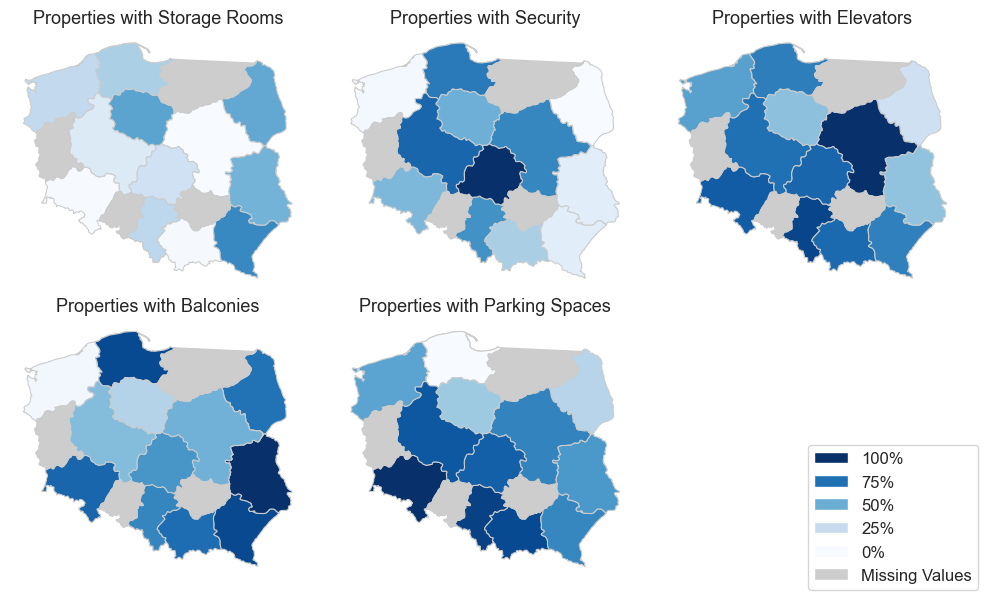

In [26]:
# Dictionary with descriptive names
column_titles = {
    'hasStorageRoom': 'Properties with Storage Rooms',
    'hasSecurity': 'Properties with Security',
    'hasElevator': 'Properties with Elevators',
    'hasBalcony': 'Properties with Balconies',
    'hasParkingSpace': 'Properties with Parking Spaces'
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

# Plot maps
for i, (variable, title) in enumerate(column_titles.items()):
    ax = axes[i]  
    merged.plot(
        column=variable, 
        cmap='Blues', 
        linewidth=0.8, 
        ax=ax, 
        edgecolor='0.8', 
        missing_kwds={'color': '#cdcdcd'} # NaN values will be shown in gray
    ) 
    ax.set_title(title,  fontsize=13)
    ax.set_axis_off()  
    ax.set_aspect(1.5) 

# Hide unused axes 
for axis in axes[i + 1:]:
    axis.set_axis_off()

# Add a custom legend
legend_elements = [
    Patch(facecolor=plt.cm.Blues(1.0), label='100%'),  
    Patch(facecolor=plt.cm.Blues(0.75), label='75%'), 
    Patch(facecolor=plt.cm.Blues(0.5), label='50%'), 
    Patch(facecolor=plt.cm.Blues(0.25), label='25%'), 
    Patch(facecolor=plt.cm.Blues(0), label='0%'),
    Patch(facecolor='#cdcdcd', label='Missing Values')
]
fig.legend(handles=legend_elements, loc='lower right', ncol=1, fontsize=12,)

plt.tight_layout()

### 3. Distance to City Center in Most Popular Cities

To assess how apartment listings are distributed based on their proximity to the city center, I analyzed four of the most popular Polish cities in the dataset. The data was grouped by city and rounded distance intervals to visualize the availability of rental properties at varying distances from the city center.


In [27]:
# Filter the dataframe
most_popular_cities = offers_per_city.reset_index().city.tail(4).values[::-1]
distance_to_city_center = df[df['city'].isin(most_popular_cities)]
distance_to_city_center.city.unique()

#round centreDistance to nearest 0.5
distance_to_city_center = distance_to_city_center.copy()
distance_to_city_center.loc[:, 'RoudedCentreDistance'] = np.round(distance_to_city_center['centreDistance'] * 2) / 2

# Reshapes data on property counts by city 
distance_to_city_center = distance_to_city_center.pivot_table(columns='RoudedCentreDistance',index='city',values='index', aggfunc='count').reset_index()
distance_to_city_center_vertical = distance_to_city_center.melt(id_vars=['city'], var_name='CentreDistance', value_name='count')

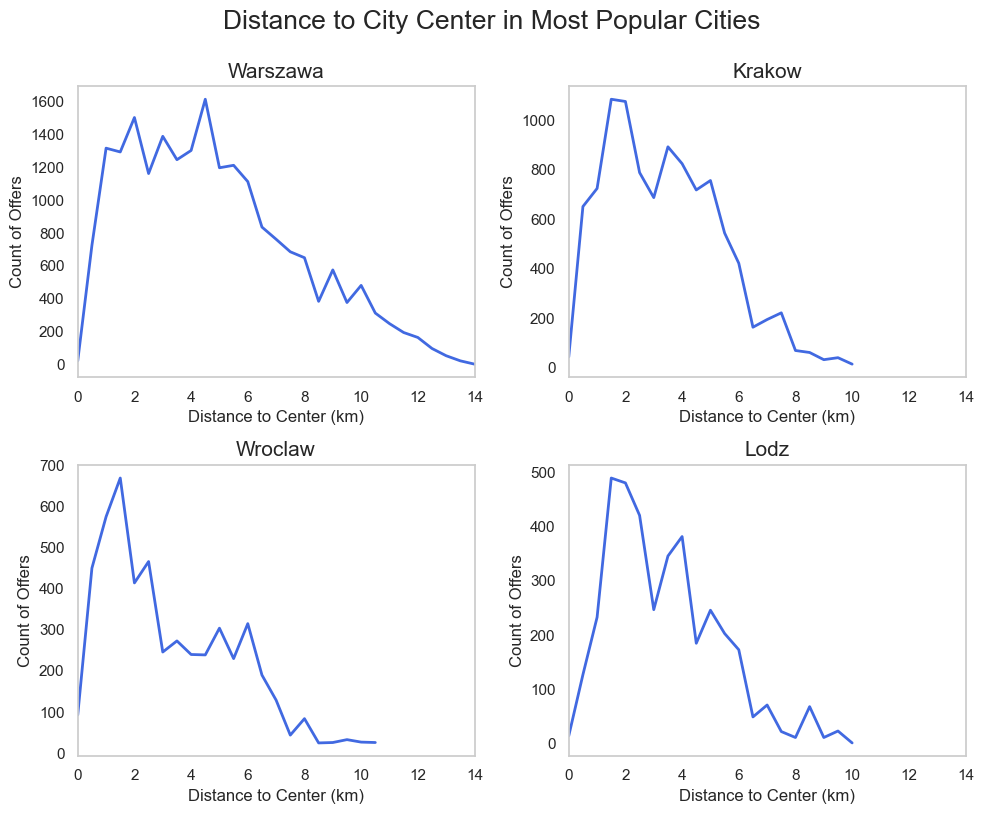

In [110]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Plot line charts
for i, city in enumerate(most_popular_cities):
    city_data = distance_to_city_center_vertical[distance_to_city_center_vertical['city'] == city]
    sns.lineplot(data=city_data, x='CentreDistance', y='count', ax=axes[i], color='royalblue', linewidth=2)
    
    axes[i].set_title(f'{city.capitalize()}', fontsize=15)  
    axes[i].set_xlabel('Distance to Center (km)', fontsize=12) 
    axes[i].set_ylabel('Count of Offers', fontsize=12)
    axes[i].set_xlim(0, 14)
    axes[i].grid(False)

fig.suptitle('Distance to City Center in Most Popular Cities', fontsize=19, y=1.015)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3)


### 4. Average distances to different facilities by city

Understanding accessibility to essential services is crucial for potential renters and investors. I calculated median distances from apartments to key amenities, such as schools, clinics, pharmacies, post offices, and restaurants.

In [29]:
# Calculates median facility distances for top cities.
avg_distances_to_facilities = (df
                               .dropna()
                               .groupby('city')[['schoolDistance', 'clinicDistance', 'postOfficeDistance', 'pharmacyDistance', 'restaurantDistance']]
                               .median()
                               .reset_index()
                            )
nine_most_popular_cities = offers_per_city.reset_index().city.tail(6).values[::-1]
avg_distances_to_facilities = avg_distances_to_facilities[avg_distances_to_facilities['city'].isin(nine_most_popular_cities)]
avg_distances_to_facilities

,city,schoolDistance,clinicDistance,postOfficeDistance,pharmacyDistance,restaurantDistance
3,gdansk,0.3700,0.755,0.3565,0.2860,0.1880
6,krakow,0.3060,0.536,0.3630,0.2450,0.1790
7,lodz,0.2920,0.666,0.5050,0.2785,0.2805
9,poznan,0.3025,0.610,0.3810,0.2180,0.1740
13,warszawa,0.2510,0.399,0.3670,0.1990,0.1300
14,wroclaw,0.2930,0.715,0.4505,0.2850,0.2530


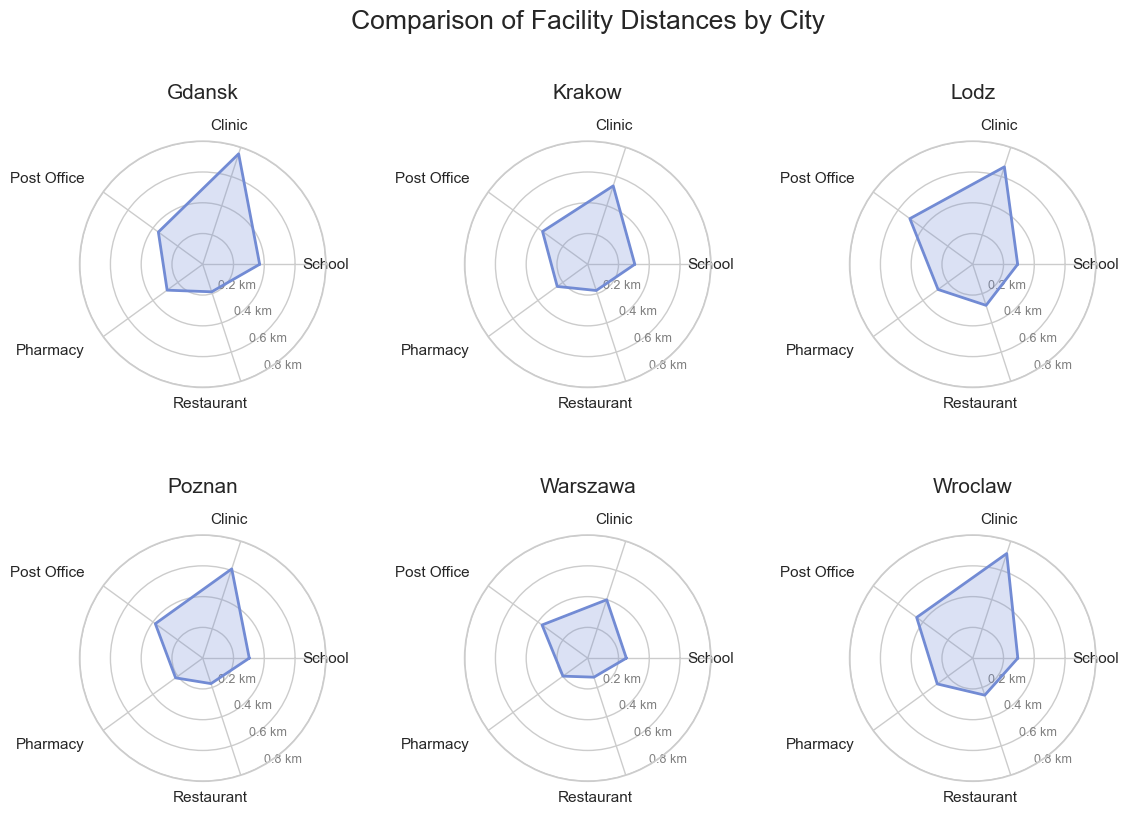

In [139]:
# Mapping facility categories to human-readable labels
category_labels = {
    'schoolDistance': 'School',
    'clinicDistance': 'Clinic',
    'postOfficeDistance': 'Post Office',
    'pharmacyDistance': 'Pharmacy',
    'restaurantDistance': 'Restaurant'
}
categories = list(category_labels.keys())
human_readable_categories = [category_labels[cat] for cat in categories]  

fig, axes = plt.subplots(2, 3, figsize=(14, 8), subplot_kw=dict(polar=True))
axes = axes.flatten()

for i, (index, row) in enumerate(avg_distances_to_facilities.iterrows()):
    city = row['city']  
    values = row[categories].values  
    values = np.concatenate((values, [values[0]]))  
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1] 

    # Plot radar chart for each city
    axes[i].plot(angles, values, linewidth=2, linestyle='solid', label=city, color='#728bd4')
    axes[i].fill(angles, values, alpha=0.25, color='#728bd4')  
    axes[i].set_xticks(angles[:-1])  
    axes[i].set_xticklabels(human_readable_categories, fontsize=11, ha='right')

    # Adjust the radar chart scale
    axes[i].set_ylim(0, 0.8)  
    axes[i].set_title(f'{city.capitalize()}', fontsize=15, y=1.14)
    axes[i].set_yticks([0.2, 0.4, 0.6, 0.8])  
    axes[i].set_yticklabels([f'{tick:.1f} km' for tick in [0.2, 0.4, 0.6, 0.8]], fontsize=9, color='gray')  

    # Title for each city's radar chart
    axes[i].set_rlabel_position(300)  

plt.tight_layout()
plt.suptitle('Comparison of Facility Distances by City', fontsize=19, y=1.065)
plt.subplots_adjust(wspace=0.1, hspace=.6,left=0.1, right=0.9, top=0.9, bottom=0.1)

### 5. Rent Price vs Distance

This section explores how rent prices are related to the distance from the city center, highlighting how properties located further away from the center are priced in relation to their distance and square meterage. By analyzing a sample of properties, I examine the pricing trends based on distance and size.

In [111]:
price_vs_distance = df[['price','centreDistance','squareMeters']].dropna()

# Simple Random Sampling
price_vs_distance = price_vs_distance.sample(n=1000, random_state=12)

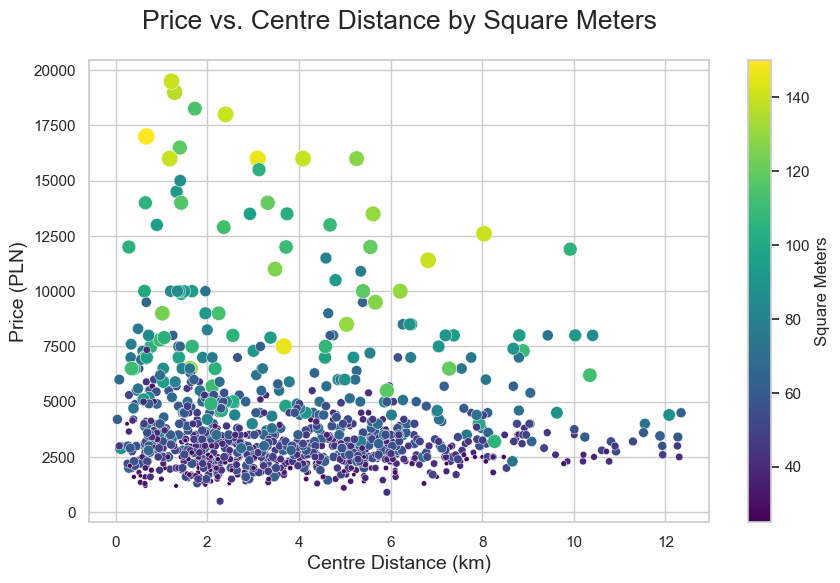

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))

# Ploting scatter lot 
scatter = sns.scatterplot(
    data=price_vs_distance,
    x='centreDistance',
    y='price',
    hue='squareMeters',             
    palette='viridis',          
    size='squareMeters',            
    sizes=(10, 150),
    legend=False,                   
    ax=ax
)

# Add Color Bar
norm = plt.Normalize(price_vs_distance['squareMeters'].min(), price_vs_distance['squareMeters'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Square Meters')      

ax.set_title('Price vs. Centre Distance by Square Meters', fontsize=19, y=1.05)
ax.set_xlabel('Centre Distance (km)', fontsize=14)
ax.set_ylabel('Price (PLN)', fontsize=14)
ax.grid(True)

### 6. Price Distribution by Number of Rooms

In this section, I analyze the distribution of property prices based on the number of rooms. Using a boxplot, I demonstrate the variation in price across different room categories, providing insights into price brackets for various apartment types.

In [114]:
# Filter valid rooms 
df_distribution_by_rooms = df[df['rooms'] > 0].copy()

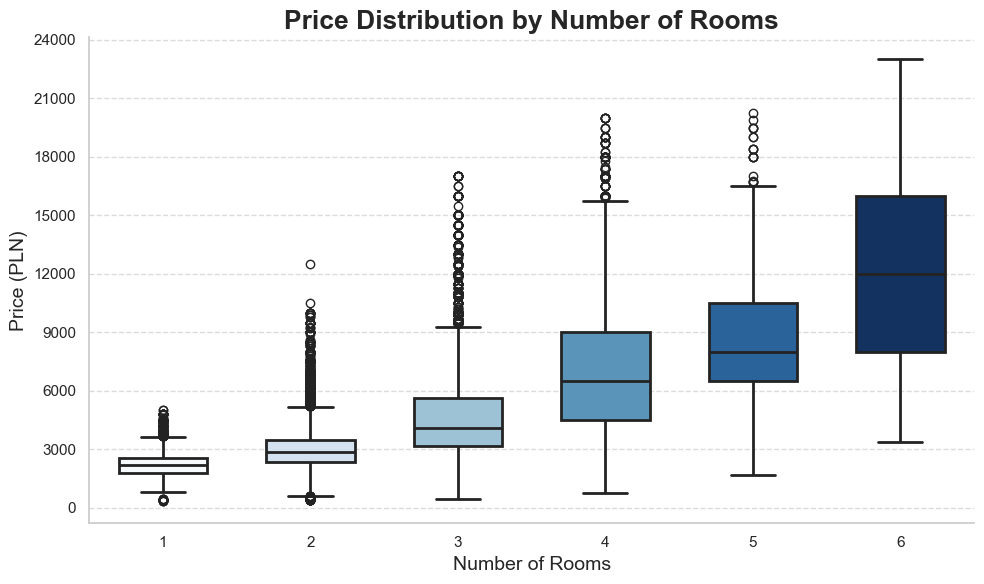

In [133]:

plt.figure(figsize=(10, 6))

# Ploting boxplot
sns.boxplot(
    data=df_distribution_by_rooms,
    x='rooms',                    
    y='price',                        
    palette='Blues',   
    hue='rooms',         
    width=0.6,
    linewidth=2,
    legend=False                         
)

plt.title('Price Distribution by Number of Rooms', fontsize=19, weight='bold')
plt.xlabel('Number of Rooms', fontsize=14)
plt.ylabel('Price (PLN)', fontsize=14)

# Format X-axis
xticks = plt.xticks()[0]  
xtick_labels = [str(int(tick + 1)) for tick in xticks] 
plt.xticks(ticks=xticks, labels=xtick_labels)

# Set y-axis ticks in 3,000 increments.
max_price = df['price'].max()
yticks = np.arange(0, max_price + 3000, 3000)  
plt.yticks(yticks)

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine() 

plt.tight_layout()

### 7. Price Trends by Build Year and Distance

This analysis explores how the age of a property affects its price, with a focus on properties located close to or farther away from the city center. By examining price trends over different build years, I provide insights into how the proximity to city centers impacts older vs. newer buildings.

In [115]:
#  Calculates median prices by build year, split by distance
age_vs_price = df.groupby('buildYear').agg({
    'price': [
        lambda x: x[df['centreDistance'] < 1.5].median(),  
        lambda x: x[df['centreDistance'] >= 1.5].median()   
    ]
}).reset_index()
age_vs_price.columns = ['buildYear','< 1.5 km', '≥ 1.5 km']
age_vs_price = age_vs_price.sort_values(by='buildYear', ascending=False).head(70)

# Melt the data for easier plotting by distance.
age_vs_price_melted = age_vs_price.melt(id_vars=['buildYear'], 
                     var_name='Distance', 
                     value_name='Price')

age_vs_price_melted.sample(3)

,buildYear,Distance,Price
72,2022.0,≥ 1.5 km,3000.0
50,1974.0,< 1.5 km,3500.0
71,2023.0,≥ 1.5 km,3200.0


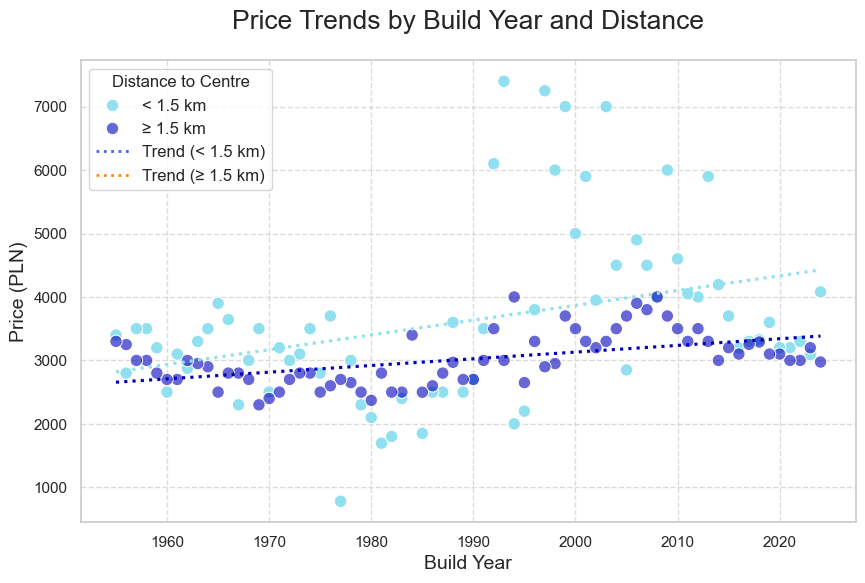

In [131]:
# Custom color palette
custom_palette = {"< 1.5 km": "#90e0ef", "≥ 1.5 km": "#00B9"}

fig, ax = plt.subplots(figsize=(10, 6))

# Ploting Scatter 
scatter = sns.scatterplot(
    data=age_vs_price_melted,  
    x="buildYear", 
    y="Price",
    hue="Distance",  
    palette=custom_palette,  
    s=80,  # Increased point size
    legend=True,  
    ax=ax
)

# Add trend lines for each Distance category
for category, color in custom_palette.items():
    sns.regplot(
        data=age_vs_price_melted[age_vs_price_melted["Distance"] == category],
        x="buildYear",
        y="Price",
        scatter=False,
        color=color,
        ci=None, 
        line_kws={"linestyle": "dotted"},
        ax=ax
    )

# add scatter and trendline legends
handles, labels = ax.get_legend_handles_labels()
legend_elements = [
    Line2D([0], [0], color="royalblue", linestyle="dotted", lw=2, label="Trend (< 1.5 km)"),
    Line2D([0], [0], color="darkorange", linestyle="dotted", lw=2, label="Trend (≥ 1.5 km)")
]
ax.legend(handles=handles + legend_elements, labels=labels + ["Trend (< 1.5 km)", "Trend (≥ 1.5 km)"],
          title="Distance to Centre", loc="upper left", fontsize=12)

ax.set_title("Price Trends by Build Year and Distance", fontsize=19, y=1.05)
ax.set_xlabel("Build Year", fontsize=14)
ax.set_ylabel("Price (PLN)", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.7)


### 8. Impact of Facilities on Property Prices

I analyze how specific apartment facilities (e.g., parking spaces, balconies, elevators, storage rooms, security) correlate with rental prices. This heatmap allows for a better understanding of how the presence of these features influences property values.

In [ ]:
# Calculates the percentage correlation between property features and price.
bool_columns = ["hasParkingSpace", "hasBalcony", "hasElevator", "hasStorageRoom", "hasSecurity"]
df_corr = df[bool_columns + ["price"]].copy()
df_corr[bool_columns] = df_corr[bool_columns].astype(int)
correlation_matrix = df_corr.corr() * 100

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'hasParkingSpace'),
  Text(0, 1.5, 'hasBalcony'),
  Text(0, 2.5, 'hasElevator'),
  Text(0, 3.5, 'hasStorageRoom'),
  Text(0, 4.5, 'hasSecurity'),
  Text(0, 5.5, 'price')])

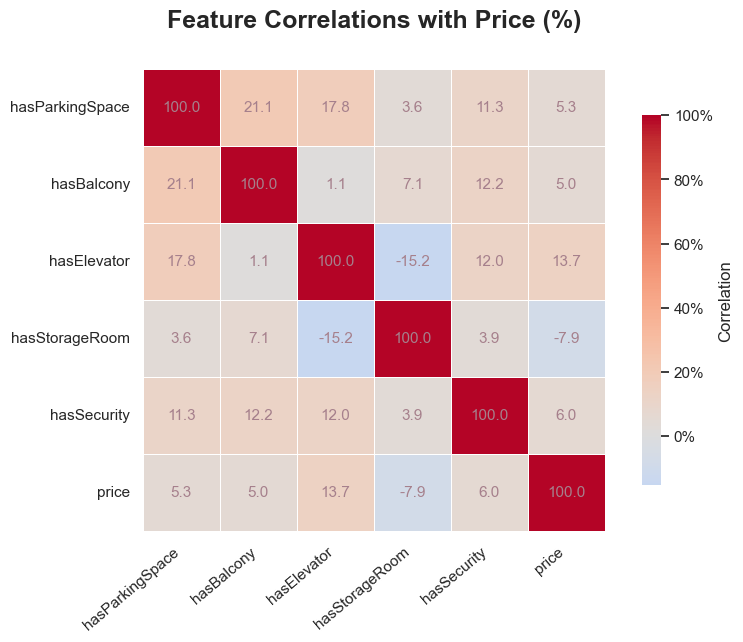

In [108]:
plt.figure(figsize=(8, 6))

# Ploting heat map
sns.heatmap(
    data=correlation_matrix, 
    annot=True, 
    fmt=".1f",  
    cmap="coolwarm", 
    center=0, 
    linewidths=0.4, 
    square=True,
    cbar_kws={"format": "%.0f%%", "label": "Correlation", "shrink": 0.8, "pad": 0.06}    ,
    annot_kws={"color": "#A6808C", "fontsize": 11}
)

plt.title("Feature Correlations with Price (%)", fontsize=18, weight="bold", pad=30)
plt.xticks(rotation=40, ha="right", fontsize=11)
plt.yticks(fontsize=11)